In [88]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [89]:
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [90]:
class MnistDataset(Dataset):
  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass

  def __len__(self):
    return len(self.data_df)
  
  def __getitem__(self, index):
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values)/255.0

    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
    plt.title("label = " + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation = 'none', cmap = 'Blues')
    pass
  
  pass

In [91]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

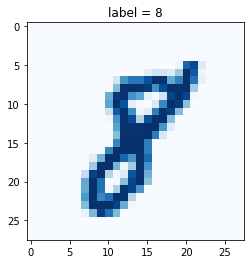

In [92]:
mnist_dataset.plot_image(17)

In [123]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784, 200), 
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    self.loss_function = nn.BCELoss()

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

In [94]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [95]:
%%time

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  D.train(generate_random(784), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 4min 5s, sys: 4.82 s, total: 4min 10s
Wall time: 4min 10s


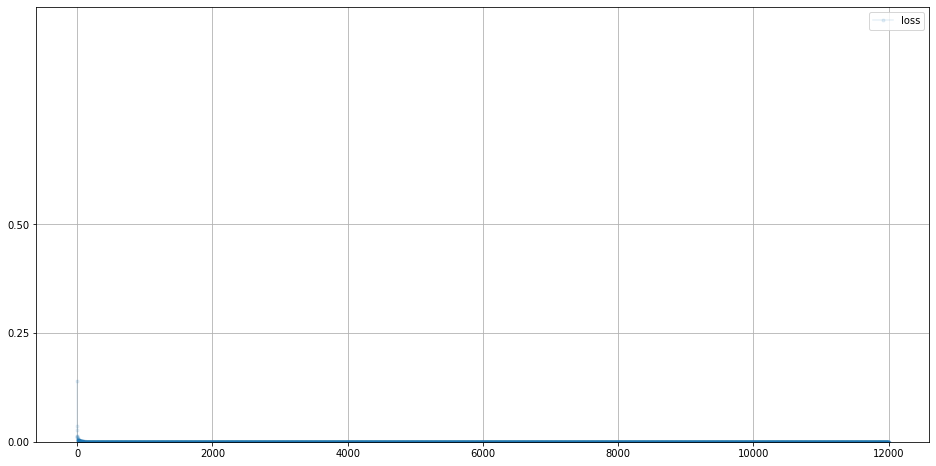

In [96]:
D.plot_progress()

In [97]:
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random(784)).item())
  pass

1.0
1.0
1.0
1.0
8.755107749891522e-12
9.970405577541808e-12
8.11032057485006e-12
8.494874942366337e-12


In [124]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(100, 200), 
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 784),
        nn.Sigmoid()
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, D, inputs, targets):
    g_output = self.forward(inputs)

    d_output = D.forward(g_output)

    loss = D.loss_function(d_output, targets)

    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

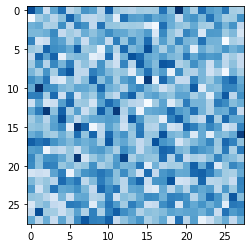

In [99]:
G = Generator()
output = G.forward(generate_random_seed(100))
img = output.detach().numpy().reshape(28, 28)
plt.imshow(img, interpolation='none', cmap = 'Blues')

In [126]:
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [127]:
%%time

D = Discriminator()
G = Generator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))

  G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 6min 59s, sys: 7.71 s, total: 7min 7s
Wall time: 7min 6s


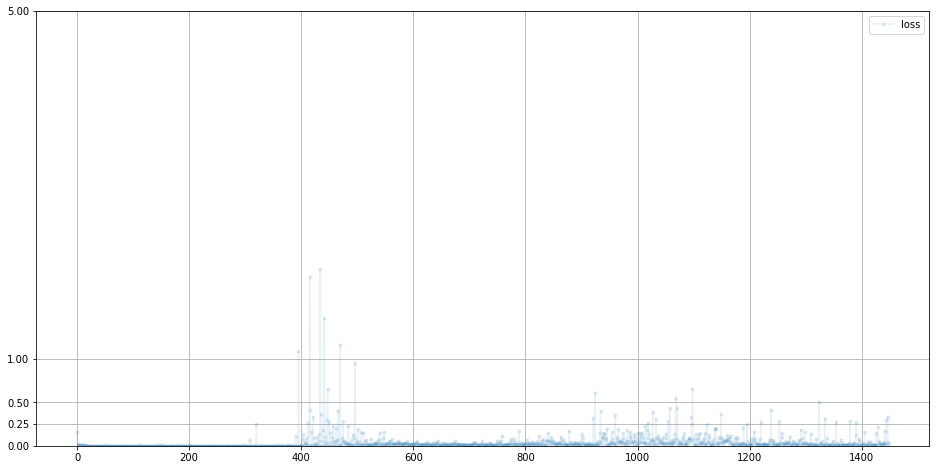

In [129]:
D.plot_progress()

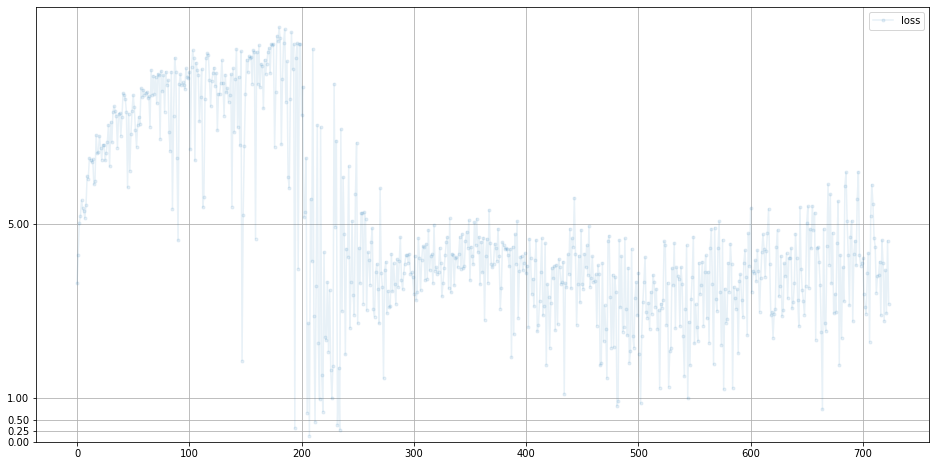

In [130]:
G.plot_progress()

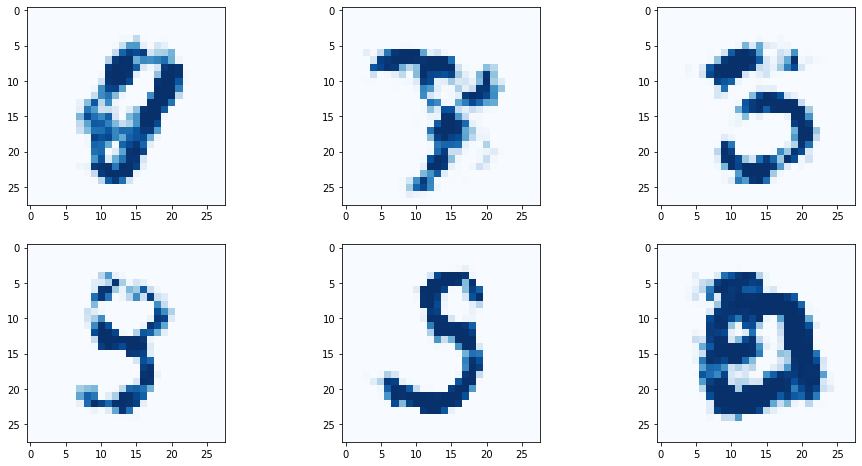

In [194]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().numpy().reshape(28, 28)
    axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass

In [134]:
%%time

epochs = 4

D = Discriminator()
G = Generator()

for i in range(epochs):
  for label, image_data_tensor, target_tensor in mnist_dataset:
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))

    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 27min 44s, sys: 29.8 s, total: 28min 14s
Wall time: 28min 13s


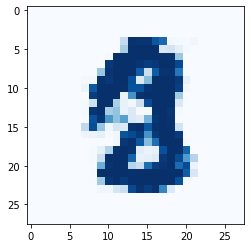

In [211]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28, 28)
plt.imshow(img1, interpolation = 'none', cmap = 'Blues')

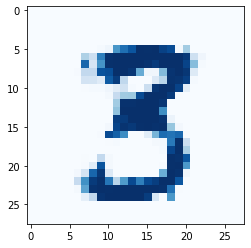

In [212]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28, 28)
plt.imshow(img2, interpolation = 'none', cmap='Blues')

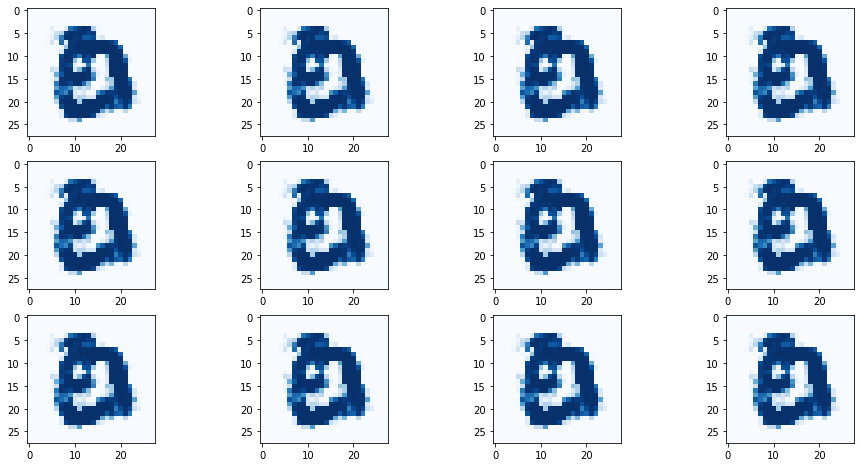

In [216]:
#시드와 시드 사이에서 일정한 간격으로 시드 생성
count = 0

#seed1 = generate_random_seed(100)
#seed2 = generate_random_seed(100)

f, axarr = plt.subplots(3, 4, figsize = (16, 8))
for i in range(3):
  for j in range(4):
    seed = seed1 + (seed2 - seed1)/11 * count
    coutput = G.forward(seed)
    img = output.detach().numpy().reshape(28, 28)
    axarr[i, j].imshow(img, interpolation = 'none', cmap='Blues')
    count = count +1
    pass
  pass

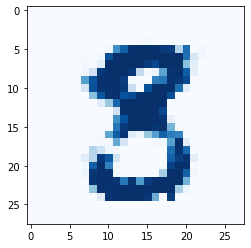

In [215]:
#시드끼리 더하는 경우 => 각 이미지를 합친 이미지를 생성
seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28, 28)
plt.imshow(img3, interpolation = 'none', cmap = 'Blues')

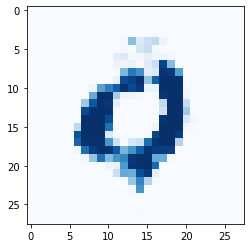

In [217]:
#시드끼리 빼는 경우 => 겹치는 부분이 빠지지는 않는다
seed4 = seed1 - seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28, 28)
plt.imshow(img4, interpolation = 'none', cmap='Blues')